# Combining OGGM's climate data with ODINN's MB model

In [1]:
## Environment and packages
using Pkg; Pkg.activate("../../."); Pkg.instantiate()

  Activating environment at `~/Desktop/Jordi/Julia/odinn_toy_model/Project.toml`


In [2]:
ENV["PYTHON"] = "/Users/Bolib001/miniconda3/envs/oggm_env/bin/python3.9" # Choose own Python environment with OGGM's installation
using PyCall
Pkg.build("PyCall")

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/299304989a5e6473d985212c28928899c74e9421/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/169bb8ea6b1b143c5cf57df6d34d022a7b60c6db/build.log`


## Import Python OGGM libraries and configure Glacier directories


A call to [cfg.initialize()](https://docs.oggm.org/en/stable/generated/oggm.cfg.initialize.html) will read the default parameter file (or any user-provided file) and make them available to all other OGGM tools via the `cfg.PARAMS` dictionary. Here are some examples of these parameters:

In this notebook we'll constantly switch between Julia and Python. The strategy so far is to do as much as possible in Julia (like storing the results and the main variables). However, there are some functions from `xarray` and `pandas` that can get messy when called from Julia, so for those cases they will be called from Python using py" code here". 

In [3]:
# Import in Julia
cfg = pyimport("oggm.cfg")
utils = pyimport("oggm.utils")
workflow = pyimport("oggm.workflow")

cfg.initialize()

2021-10-11 16:49:58: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-10-11 16:49:58: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-10-11 16:49:58: oggm.cfg: Multiprocessing: using all available processors (N=8)


### Whenever we want to modify a field from a class we need to create a Julian instance:

In [4]:
PARAMS = PyDict(cfg."PARAMS")

PyDict{PyAny, PyAny, true} with 107 entries:
  "has_internet"            => true
  "dl_cache_readonly"       => false
  "use_multiprocessing"     => false
  "use_mp_spawn"            => false
  "mp_processes"            => 8
  "lru_maxsize"             => 100
  "continue_on_error"       => false
  "grid_dx_method"          => "square"
  "topo_interp"             => "cubic"
  "use_intersects"          => true
  "use_compression"         => true
  "border"                  => 40
  "mpi_recv_buf_size"       => 131072
  "use_multiple_flowlines"  => true
  "filter_min_slope"        => true
  "auto_skip_task"          => false
  "correct_for_neg_flux"    => true
  "filter_for_neg_flux"     => false
  "run_mb_calibration"      => false
  "rgi_version"             => "62"
  "use_rgi_area"            => true
  "compress_climate_netcdf" => true
  "use_tar_shapefiles"      => true
  "clip_mu_star"            => false
  "clip_tidewater_border"   => true
  ⋮                         => ⋮

In [5]:
PARAMS["prcp_scaling_factor"], PARAMS["ice_density"], PARAMS["continue_on_error"]
PARAMS["use_multiprocessing"] = true # Let's use multiprocessing

2021-10-11 16:50:00: oggm.cfg: Multiprocessing switched ON after user settings.


true

Each OGGM run needs a **single folder** where to store the results of the computations for all glaciers. This is called a "working directory" and needs to be specified before each run.

In [6]:
PATHS = PyDict(cfg."PATHS")

PyDict{PyAny, PyAny, true} with 7 entries:
  "dl_cache_dir" => "/Users/Bolib001/OGGM/download_cache"
  "tmp_dir"      => "/Users/Bolib001/OGGM/tmp"
  "rgi_dir"      => "/Users/Bolib001/OGGM/rgi"
  "test_dir"     => "/Users/Bolib001/OGGM/tests"
  "working_dir"  => ""
  "dem_file"     => ""
  "climate_file" => ""

In [7]:
PATHS["working_dir"] = "/Users/Bolib001/Jordi/Python/OGGM_data"

"/Users/Bolib001/Jordi/Python/OGGM_data"

**This working directory is meant to be persistent**, i.e. you can stop your processing workflow after any task, and restart from an existing working directory at a later stage.

### Define the glaciers for the run 

In [8]:
rgi_ids = ["RGI60-11.01450"]

1-element Vector{String}:
 "RGI60-11.01450"

### Glacier directories 

The OGGM workflow is organized as a list of **tasks** that have to be applied to a list of glaciers. The vast majority of tasks are called **entity tasks**: they are standalone operations to be realized on one single glacier entity. These tasks are executed sequentially (one after another): they often need input generated by the previous task(s): for example, the climate calibration needs the glacier flowlines, which can be only computed after the topography data has been processed, and so on.

To handle this situation, OGGM uses a workflow based on data persistence on disk: instead of passing data as python variables from one task to another, each task will read the data from disk and then write the computation results back to the disk, making these new data available for the next task in the queue.

These glacier specific data are located in [glacier directories](https://docs.oggm.org/en/stable/glacierdir.html#glacier-directories). In the model, these directories are initialized with the following command (this can take a little while on the first call, as OGGM needs to download some data):

In [9]:
# use elevation band  flowlines
base_url = ("https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands")

# Where to fetch the pre-processed directories
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=2,
                                          prepro_border=10,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version="62")
# gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3, prepro_border=80)
gdir = gdirs[1]
println("Path to the DEM:", gdir.get_filepath("dem"))

Path to the DEM:/Users/Bolib001/Jordi/Python/OGGM_data/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01450/dem.tif


2021-10-11 16:50:03: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-10-11 16:50:03: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-10-11 16:50:03: oggm.utils: /Users/Bolib001/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-11/RGI60-11.01.tar verified successfully.


In [10]:
using PyPlot
graphics = pyimport("oggm.graphics")

PyObject <module 'oggm.graphics' from '/Users/Bolib001/Python/oggm/oggm/graphics.py'>

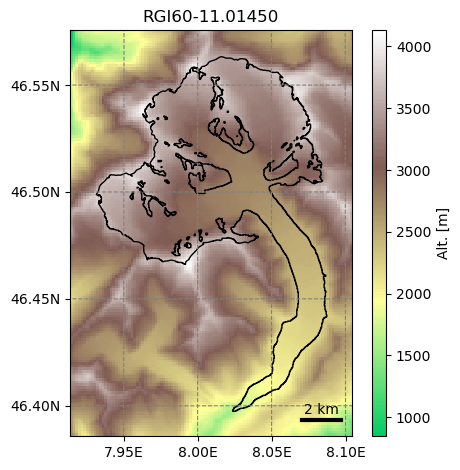

In [11]:
graphics.plot_domain(gdirs)

Another advantage of glacier directories is their persistence on disk: once created, **they can be recovered from the same location** by using `init_glacier_directories` again, but without keyword arguments:

In [12]:
# Fetch the LOCAL pre-processed directories - note that no arguments are used!
# gdirs = workflow.init_glacier_directories(rgi_ids)

We import the simple ODINN MB model

In [13]:
using Dates # to provide correct Julian time slices 

xr = pyimport("xarray")
np = pyimport("numpy")

PyObject <module 'numpy' from '/Users/Bolib001/miniconda3/envs/oggm_env/lib/python3.9/site-packages/numpy/__init__.py'>

In [14]:
gdir = gdirs[1]

PyObject <oggm.GlacierDirectory>
  RGI id: RGI60-11.01450
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 82.206 km2
  Lon, Lat: (8.01919, 46.5028)
  Grid (nx, ny): (107, 154)
  Grid (dx, dy): (137.0, -137.0)


We extract the climate data for the period with MB observations. The raw OGGM climate data has a monthly resolution.

We use the W5E5 climate with daily temperature and precipitation and a changing lapse rate (data from ERA5)

In [15]:
MBsandbox = pyimport("MBsandbox.mbmod_daily_oneflowline")

PyObject <module 'MBsandbox.mbmod_daily_oneflowline' from '/Users/Bolib001/Python/massbalance-sandbox/MBsandbox/mbmod_daily_oneflowline.py'>

In [16]:
mb_type = "mb_real_daily"
grad_type = "var_an_cycle" # could use here as well 'cte'
# mb_mod = MBsandbox.TIModel(gdir, nothing, mb_type=mb_type, grad_type=grad_type, baseline_climate=climate, residual=0)
# fs = "_daily_".*climate
fs = "_daily_W5E5"

"_daily_W5E5"

## Producing the climate and mass balance training dataset

### Seasonal climate data to match MB observations

TODO: improve separation of rain/snow.

In [17]:
# Function to convert the baseline OGGM climate dataset to 2D
function create_2D_climate_data(climate, g_dem)
    # Create dummy 2D arrays to have a base to apply gradients afterwards
    temp_2D = climate.temp.data .* ones(size(permutedims(g_dem.data, (1,2,3))))
    snow_2D = climate.prcp.data .* ones(size(permutedims(g_dem.data, (1,2,3))))
    rain_2D = climate.prcp.data .* ones(size(permutedims(g_dem.data, (1,2,3))))

    # We generate a new dataset with the scaled data
    climate_2D = xr.Dataset(
        data_vars=Dict([
            ("temp", (["time","y","x"], temp_2D)),
            ("snow", (["time","y","x"], snow_2D)),
            ("rain", (["time","y","x"], rain_2D)),
            ("gradient", (["time"], climate.gradient.data))
            ]),
        coords=Dict([
            ("time", climate.time),
            ("x", g_dem.x),
            ("y", g_dem.y)
        ]),
        attrs=climate.attrs
    )

    return climate_2D

end

create_2D_climate_data (generic function with 1 method)

In [18]:
# Function to apply temperature lapse rates to the full matrix of a glacier
function apply_t_grad!(climate, g_dem, gradient_bounds=[-0.009, -0.003], default_grad=-0.0065)
    gradients = utils.clip_array(climate.gradient, gradient_bounds[1], gradient_bounds[2]) # Clip gradients within plausible values

    # We apply the gradients to the temperature
    climate.temp.data = climate.temp.data .+ gradients.data .* (g_dem.data .- climate.ref_hgt)
    # We adjust the rain/snow fractions with the updated temperature
    climate.snow.data = climate.snow.where(climate.temp < 0, 0).data
    climate.rain.data = climate.rain.where(climate.temp > 0, 0).data
end

apply_t_grad! (generic function with 3 methods)

In [46]:
# TODO: correctly retrieve the glacier coordinates to plot them in `imshow` as an extent
function plot_monthly_map(climate, variable, year)
    climate = climate[variable].where(climate.time.dt.year == year, drop=true).groupby("time.month")
    fig_clim, ax_clim = pplt.subplots([1:6, 7:12], axheight=2)
    fig_clim.format(
        abc=true, abcloc="ul", suptitle= ("$year - monthly $variable")
    )
    for mon in 1:12
        if variable == "temp"
            m_var = ax_clim[mon].imshow(climate.mean()[mon], cmap="Thermal", 
                    vmin=minimum(climate.mean().data), vmax=maximum(climate.mean().data)) # set common min max temp
        else
            m_var = ax_clim[mon].imshow(climate.sum()[mon], cmap="DryWet", 
                    vmin=climate.sum().min().data, vmax=climate.sum().max().data) # set common min max precipitation
        end
        ax_clim[mon].set_title(Dates.monthname(mon))
        if(mon == 12)
            if variable == "temp"
                fig_clim.colorbar(m_var, label="Air temperature (°C)")
            else
                fig_clim.colorbar(m_var, label="Accumulated $variable (mm)")
            end
        end
    end
end

plot_monthly_map (generic function with 1 method)

We classify the climate dataset into ablation and accumulation seasons

In [20]:
function is_abl(month)
    return (month >= 4) & (month <= 10)
end

function is_acc(month)
    return (month <= 4) | (month >= 10)
end

is_acc (generic function with 1 method)

Now we have a climate dataset for a given glacier ready to be used for training. We have 2D grid values for scaled air temperature at each glacier altitude, and the corresponding fractions of snow and rain.

In [21]:
function get_raw_climate_data(gdir, temp_resolution="daily", climate="W5E5")
    PARAMS["hydro_month_nh"]=1
    MBsandbox.process_w5e5_data(gdir, climate_type=climate, temporal_resol=temp_resolution) 
    fpath = gdir.get_filepath("climate_historical", filesuffix="_daily_W5E5")
    climate = xr.open_dataset(fpath)

    # Convert climate dataset to 2D based on the glacier's DEM
    g_dem = xr.open_rasterio(gdir.get_filepath("dem"))
    climate_2D = create_2D_climate_data(climate, g_dem)

    return climate_2D
end

get_raw_climate_data (generic function with 3 methods)

In [22]:
# Convert Pythonian date to Julian date
function jldate(pydate)
    return Date(pydate.dt.year.data[1], pydate.dt.month.data[1], pydate.dt.day.data[1])
end

jldate (generic function with 1 method)

In [23]:
function trim_period(period, climate)
    if any(climate.time[1].dt.date.data[1] > period[1])
        head = jldate(climate.time[1])
        period = Date(year(head), 10, 1):Day(1):period[end] # make it a hydrological year
    end
    if any(climate.time[end].dt.date.data[1] < period[end])
        tail = jldate(climate.time[end])
        period = period[1]:Day(1):Date(year(tail), 9, 30) # make it a hydrological year
    end

    return period
end

trim_period (generic function with 1 method)

In [24]:
# Compute climate forcings for a given period to feed MB model
function get_climate_forcing(gdir, climate, period, season)
    @assert any(season .== ["annual","accumulation", "ablation"]) "Wrong season type, must be `annual`, `accumulation` or `ablation`"

    # Make sure the desired period is covered by the climate data
    period = trim_period(period, climate) 
    @assert any((climate.time[1].dt.date.data[1] <= period[1]) & any(climate.time[end].dt.date.data[1] >= period[end])) "No overlapping period available between climate and MB data!" 
    clim_period = climate.sel(time=period) # Crop desired time period

    if season == "accumulation"
        clim_period = clim_period.sel(time=is_acc.(clim_period.time.dt.month.data))
    elseif season == "ablation"
        clim_period = clim_period.sel(time=is_abl.(clim_period.time.dt.month.data))
    end
        
    # Get glacier DEM
    g_dem = xr.open_rasterio(gdir.get_filepath("dem"))
    # Apply temperature gradients and compute snow/rain fraction for the selected period
    apply_t_grad!(clim_period, g_dem)
    # Obtained PDDs and cumulative snowfall and rain
    # clim_period.temp.data = clim_period.temp.where(clim_period.temp.data .> 0, 0) # PDDs
    clim_period = clim_period.drop("gradient") #.sum() # Accumulate everything

    return clim_period
     
end

get_climate_forcing (generic function with 1 method)

We need a function to retrieve all the necessary climate data matching the glaciological mass balance observations of a reference glacier

In [136]:
function to_hydro_period(mass_balance::PyObject, trim_edges=true)
    # Select hydro period between October 1st and 30th of September
    if trim_edges
        hydro_period = collect(Date(mass_balance.index[1],10,1):Day(1):Date(mass_balance.index[end]-1,09,30))
    else
        hydro_period = collect(Date(mass_balance.index[1]-1,10,1):Day(1):Date(mass_balance.index[end],09,30))
    end

    return hydro_period
end

function to_hydro_period(years::Array)
    # Select hydro period between October 1st and 30th of September
    hydro_period = collect(Date(years[1]-1,10,1):Day(1):Date(years[end],09,30))

    return hydro_period
end

to_hydro_period (generic function with 3 methods)

And now we have everything we need to generate the dataset to train the mass balance model

In [26]:
# Metastructure to store xarray dataset with MB and climate data for training
struct Dataset
    annual
    accumulation
    ablation
end

In [27]:
function gen_MB_train_dataset(gdir, fs)
    # Retrieve reference MB data
    println("Downloading climate data for glacier...")
    climate = get_raw_climate_data(gdir)

    println("Fetching mass balance reference data...")
    mb_glaciological = gdir.get_ref_mb_data(input_filesuffix=fs)
    # Get hydrological period matching the reference MB data
    hydro_period = to_hydro_period(mb_glaciological)

    println("Processing data for reference period ", hydro_period[1], " - ", hydro_period[end])
    # Get the climate forcings for the MB data
    seasons = ["annual", "accumulation", "ablation"]
    balances = ["ANNUAL_BALANCE", "WINTER_BALANCE", "SUMMER_BALANCE"]

    # Build the training and reference dataset including annual and seasonal data
    ds_clim_buffer, ds_MB_buffer = [],[]
    for (season, balance) in zip(seasons, balances)
        season_MB = mb_glaciological[balance]
        MB_clim = get_climate_forcing(gdir, climate, hydro_period, season)
        push!(ds_MB_buffer, season_MB) 
        push!(ds_clim_buffer, MB_clim)
    end

    # Store everything in a global dataset 
    println("Storing data in metadataset")
    MB_ds = Dataset(ds_MB_buffer...) # splat it!!!
    climate_ds = Dataset(ds_clim_buffer...)

    return MB_ds, climate_ds        
end

gen_MB_train_dataset (generic function with 1 method)

In [28]:
MB_ds, climate_ds = gen_MB_train_dataset(gdir, fs)

Fetching mass balance reference data...
Processing data for reference period 1978-10-01

2021-10-11 16:50:14: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2021-10-11 16:50:14: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.01450) process_w5e5_data
2021-10-11 16:50:14: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc
2021-10-11 16:50:14: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_pr_global_daily_flat_glaciers_1979_2019.nc
2021-10-11 16:50:14: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_glacier_invariant_flat.nc
2021-10-11 16:50:21: oggm.utils: /Users/Bolib001/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_lapserates_monthly.nc verified successfully.


 - 1999-09-30
Storing data in metadataset


(Dataset(PyObject YEAR
1979    -508.0
1980     624.0
1981     -23.0
1982    -362.0
1983    -317.0
1984     180.0
1985    -318.0
1986    -814.0
1987    -194.0
1988    -791.0
1989    -680.0
1990    -941.0
1991   -1106.0
1992   -1511.0
1993     -93.0
1994    -271.0
1995     -24.0
1996    -448.0
1997    -520.0
1998   -1226.0
1999    -502.0
Name: ANNUAL_BALANCE, dtype: float64, PyObject YEAR
1979    1007.0
1980    1340.0
1981    1004.0
1982     890.0
1983    1269.0
1984     989.0
1985     861.0
1986     950.0
1987    1263.0
1988     779.0
1989     737.0
1990     587.0
1991     751.0
1992     337.0
1993     932.0
1994    1180.0
1995    1318.0
1996     507.0
1997     863.0
1998     630.0
1999     929.0
Name: WINTER_BALANCE, dtype: float64, PyObject YEAR
1979   -1515.0
1980    -716.0
1981   -1027.0
1982   -1252.0
1983   -1586.0
1984    -809.0
1985   -1179.0
1986   -1764.0
1987   -1457.0
1988   -1570.0
1989   -1417.0
1990   -1528.0
1991   -1857.0
1992   -1848.0
1993   -1025.0
1994   -1451.0
199

We display the downscaled temperatures to make sure everything is fine.

In [29]:
# Use ProPlot for serious scientific plots with lots of subplots
pplt = pyimport("proplot")

PyObject <module 'proplot' from '/Users/Bolib001/miniconda3/envs/oggm_env/lib/python3.9/site-packages/proplot/__init__.py'>

In [54]:
plot_monthly_map(climate_ds.annual, "rain", 1995)

We prepare the dataset with predictors and targets to train the MB model.

We can also obtain the geodetic mass balance data from Hugonnet el al (2021)

In [31]:
pd = pyimport("pandas")

# get the geodetic data for calibration
url = "https://cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv"
path = utils.file_downloader(url)
pd_geodetic = pd.read_csv(path, index_col="rgiid")

pd_geodetic = get(pd_geodetic.loc, pd_geodetic.period == "2000-01-01_2020-01-01")
mb_geodetic = get(pd_geodetic.loc, rgi_ids).dmdtda.values * 1000

years = range(2000, 2020, step=1)

2021-10-11 15:23:36: oggm.utils: /Users/Bolib001/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv verified successfully.


2000:1:2020

## Mass balance UDE model

We build a UDE MB model, using the OGGM glacier directory data for training.

In [58]:
using Base: @kwdef
@kwdef mutable struct Hyperparameters
    batchsize::Int = 25    # batch size
    η::Float64 = 0.01   # learning rate
    epochs::Int = 25        # number of epochs
end

Hyperparameters

In [59]:
using Flux

hyparams = Hyperparameters()

# Leaky ReLu as activation function
leakyrelu(x, a=0.01) = max(a*x, x)
relu_acc(x) = min(max(1, x), 2)
relu_abl(x) = min(max(3, x), 12)

# Define the networks 1->5->5->5->1
global Up = Chain(
    Dense(1,10,initb = Flux.glorot_normal), 
    BatchNorm(10, leakyrelu),
    Dense(10,10,initb = Flux.glorot_normal), 
    BatchNorm(10, leakyrelu),
    Dense(10,5,initb = Flux.glorot_normal), 
    BatchNorm(5, leakyrelu),
    Dense(5,1, relu_acc, initb = Flux.glorot_normal)
)

global Ut = Chain(
    Dense(1,10,initb = Flux.glorot_normal), 
    BatchNorm(10, leakyrelu),
    Dense(10,10,initb = Flux.glorot_normal), 
    BatchNorm(10, leakyrelu),
    Dense(10,5,initb = Flux.glorot_normal), 
    BatchNorm(5, leakyrelu),
    Dense(5,1, relu_abl, initb = Flux.glorot_normal)
)

Chain(
  Dense(1, 10),                         # 20 parameters
  BatchNorm(10, leakyrelu),             # 20 parameters, plus 20
  Dense(10, 10),                        # 110 parameters
  BatchNorm(10, leakyrelu),             # 20 parameters, plus 20
  Dense(10, 5),                         # 55 parameters
  BatchNorm(5, leakyrelu),              # 10 parameters, plus 10
  Dense(5, 1, relu_abl),                # 6 parameters
)         # Total: 14 trainable arrays, 241 parameters,
          # plus 6 non-trainable, 50 parameters, summarysize 2.316 KiB.

In [60]:
# Temperature-index equation for point glacier mass balance
function MB(P, T, Up, Ut, T_melt=0)
    MB = P.*Up - max.(T.-T_melt, 0).*Ut
    return MB
end

MB (generic function with 2 methods)

In [61]:
# We determine the loss function
function loss(batch)
    l, l_acc, l_abl = 0.0f0, 0.0f0, 0.0f0
    num = 0
    for (x, y) in batch

        # Make NN predictions
        p_batch = x[1,:]'
        t_batch = x[2,:]'
        pdd_batch = max.(t_batch.-0, 0)
        Ŷp = Up(p_batch)
        Ŷt = Ut(pdd_batch)
        
        # We evaluate the MB as the combination of Accumulation - Ablation         
        w_pc=1000
        l_MB = sqrt(Flux.Losses.mse(MB(p_batch, t_batch, Up, Ut), y; agg=mean))
        l_range_acc = sum((max.((Ŷp/p_batch).-110, 0)).*w_pc)
        l_range_abl = sum((max.((Ŷt/pdd_batch).-110, 0)).*w_pc)

        #l += l_MB 
        l += l_MB + l_range_acc + l_range_abl
        l_acc += l_range_acc
        l_abl += l_range_abl
        num +=  size(x, 2)

        # println("Accumulation loss: ", l_range_acc)
        # println("Ablation loss: ", l_range_abl)

    end

    return l/num
end

loss (generic function with 1 method)

In [62]:
# Function to produce batches. In order to use different batches do: data[ids[index]]
function produce_batches(nb_data::Int, nb_data_per_chunk::Int)
    nb_chunks = ceil(Int, nb_data / nb_data_per_chunk)
    ids = UnitRange{Int}[]
    for which_chunk = 1:nb_chunks
        id_start::Int = 1 + nb_data_per_chunk * (which_chunk - 1)
        id_end::Int = id_start - 1 + nb_data_per_chunk
        if id_end > nb_data
            id_end = nb_data
        end
        push!(ids, id_start:id_end)
    end
    return ids
end

produce_batches (generic function with 1 method)

In [63]:
function train!(Up, Ut, climate_ds, MB_ds, batch_ids, opt, season)
    # Retrieve model parameters
    θ_Up = Flux.params(Up)
    θ_Ut = Flux.params(Ut)

    field = Symbol(season)

    println("Training on $season season...")

    ids = batch_ids[season]

    for nbatch in 1:length(ids)

        
        getproperty(MB_ds,field)

        Y = getproperty(MB_ds,field).values[ids[nbatch]] # Retrieve reference MB data for the batch
        batch_period = getproperty(MB_ds,field).index[ids[nbatch]] # Retrieve years
        X = climate_ds.sel(to_hydro_period(batch_period[1:end-1]))

        # Compute gradients 
        loss_Up, back_Up = Zygote.pullback(() -> loss(batch), θ_Up)
        loss_Ut, back_Ut = Zygote.pullback(() -> loss(batch), θ_Ut)

        # Apply back() to the correct type of 1.0 to get the gradient of loss.
        ∇_Up = back_Up(one(loss_Up))
        ∇_Ut = back_Ut(one(loss_Ut))
        
        # Apply gradients to model parameters
        Flux.update!(opt, θ_Up, ∇_Up)
        Flux.update!(opt, θ_Ut, ∇_Ut)
    end
end

train! (generic function with 1 method)

In [64]:
# Generate training batches for reference MB data
batch_ids_an = produce_batches(length(MB_ds.annual), hyparams.batchsize)
batch_ids_acc = produce_batches(length(MB_ds.accumulation), hyparams.batchsize)
batch_ids_abl = produce_batches(length(MB_ds.ablation), hyparams.batchsize)

batch_ids = Dict("annual"=>batch_ids_an, "accumulation"=>batch_ids_acc, "ablation"=>batch_ids_abl)

Dict{String, Vector{UnitRange{Int64}}} with 3 entries:
  "annual"       => [1:21]
  "ablation"     => [1:21]
  "accumulation" => [1:21]

In [93]:
field = Symbol("accumulation")
getproperty(MB_ds,field)

PyObject YEAR
1979    1007.0
1980    1340.0
1981    1004.0
1982     890.0
1983    1269.0
1984     989.0
1985     861.0
1986     950.0
1987    1263.0
1988     779.0
1989     737.0
1990     587.0
1991     751.0
1992     337.0
1993     932.0
1994    1180.0
1995    1318.0
1996     507.0
1997     863.0
1998     630.0
1999     929.0
Name: WINTER_BALANCE, dtype: float64

In [70]:
batch_period = MB_ds["accumulation"].index[batch_ids["accumulation"][1]]

LoadError: MethodError: no method matching getindex(::Dataset, ::String)

In [98]:
batch_ids["accumulation"][1]

1:21

In [103]:
batch_period = getproperty(MB_ds,Symbol("accumulation")).index.values[batch_ids["accumulation"][1]]


21-element Vector{Int64}:
 1979
 1980
 1981
 1982
 1983
 1984
 1985
 1986
 1987
 1988
 1989
 1990
 1991
 1992
 1993
 1994
 1995
 1996
 1997
 1998
 1999

In [135]:
to_hydro_period(batch_period[batch_ids["accumulation"][1]][2:end-1])

6940-element Vector{Date}:
 1979-10-01
 1979-10-02
 1979-10-03
 1979-10-04
 1979-10-05
 1979-10-06
 1979-10-07
 1979-10-08
 1979-10-09
 1979-10-10
 1979-10-11
 1979-10-12
 1979-10-13
 ⋮
 1998-09-19
 1998-09-20
 1998-09-21
 1998-09-22
 1998-09-23
 1998-09-24
 1998-09-25
 1998-09-26
 1998-09-27
 1998-09-28
 1998-09-29
 1998-09-30

In [137]:
getproperty(climate_ds,Symbol("accumulation")).sel(time=to_hydro_period(batch_period[batch_ids["accumulation"][1]])) 

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/Bolib001/.julia/packages/PyCall/BD546/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'KeyError'>
KeyError("not all values found in index 'time'")
  File "/Users/Bolib001/miniconda3/envs/oggm_env/lib/python3.9/site-packages/xarray/core/dataset.py", line 2474, in sel
    pos_indexers, new_indexes = remap_label_indexers(
  File "/Users/Bolib001/miniconda3/envs/oggm_env/lib/python3.9/site-packages/xarray/core/coordinates.py", line 421, in remap_label_indexers
    pos_indexers, new_indexes = indexing.remap_label_indexers(
  File "/Users/Bolib001/miniconda3/envs/oggm_env/lib/python3.9/site-packages/xarray/core/indexing.py", line 117, in remap_label_indexers
    idxr, new_idx = index.query(labels, method=method, tolerance=tolerance)
  File "/Users/Bolib001/miniconda3/envs/oggm_env/lib/python3.9/site-packages/xarray/core/indexes.py", line 232, in query
    raise KeyError(f"not all values found in index {coord_name!r}")


In [ ]:
# We train the mass balance hybrid model
@epochs hyparams.epochs hybrid_train!(Up, Ut, climate_ds, MB_ds, batch_ids, opt)